In [ ]:
!pip install transformers
!pip install datasets 
!pip install pandas
!pip install evaluate 
!pip install accelerate
!pip install numpy
!pip install sklearn
!pip install openpyxl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import transformers
import datasets
import pandas as pd
import evaluate
import accelerate
import numpy as np
import sklearn
import openpyxl

from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
from transformers import BertTokenizer, BertForMaskedLM, AutoTokenizer, AutoModel, BertForSequenceClassification, AutoModelForSequenceClassification
from transformers import InputExample, InputFeatures, DataCollatorWithPadding

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from transformers import AdamW
from transformers import get_scheduler
from accelerate import Accelerator
from tqdm.auto import tqdm
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
import torch.nn.init as init
from torch import argmax
from torch import no_grad

import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
#Importing the dataseet 'DanishClassificationClimataDataset.csv'
df = pd.read_csv('/content/drive/MyDrive/DL_klimabert/DanishClassificationClimateDataset.csv', index_col = 0)
    
df.loc[df.Climate == df.Climate.unique()[2]] = '0'
df.Climate = pd.to_numeric(df.Climate)
df.rename(columns={'Comment': 'text', 'Climate': 'label'}, inplace=True)

#Splitting into train and test sets
train, test = train_test_split(df, test_size=0.1)

train_final = datasets.Dataset.from_dict(train)
test_final = datasets.Dataset.from_dict(test)

dataset_dict = datasets.DatasetDict({"train":train_final,"test":test_final, })
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
#import tokenizer and model 
klima_bert = "jonahank/KlimaBERT"
danish_bert = "Maltehb/danish-bert-botxo"

model_name =  klima_bert #danish_bert
labels = train['label'].nunique()

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = labels) 


#tokenize data
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length = 512, padding='max_length')

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

In [ ]:
batch_size = 16 
epoch_nr = 100

#preparing the data via dataloader
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)


In [ ]:
#This is to check that our batch has the proper dimensions and column
#for batch in train_dataloader:
#    break
#{k: v.shape for k, v in batch.items()}

# setting up lists for handling loss/accuracy
train_accuracies, eval_accuracies = [],[]
train_losses, eval_losses = [],[]

train_targs, train_preds = [], []
eval_targs, eval_preds = [],[]

f1_eval_all, f1_train_all  = [], []
roc_auc_train_all, roc_auc_eval_all= [], []

### Initializing model and optimizer
accelerator = Accelerator()
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=labels)
optimizer = AdamW(model.parameters(), 
                  lr=5e-5, weight_decay=0.01)

### Preparing training and evaluation datasets 
train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

# Setting the scheduler
num_epochs = epoch_nr
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):    
    #----------------### The training loop ####---------------
    model.train()
    cur_train_targs, cur_train_preds = [],[]
    train_loss = 0
    
    for batch in train_dl:
        outputs = model(**batch)
        
        #Predictions
        logits = outputs.logits
        predictions = argmax(logits, dim=-1)
        
        cur_train_targs += batch["labels"].tolist() 
        cur_train_preds += predictions.tolist()    
        
        #Losses
        loss = outputs.loss
        accelerator.backward(loss)
        train_loss += loss 

        #Optimizer step
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        progress_bar.update(1)
    
    #----------------### The evaluation loop ####---------------
    model.eval()
    cur_eval_targs, cur_eval_preds = [],[]
    eval_loss = 0
    metric = evaluate.load("glue", "mrpc")

    for batch in eval_dl:
        #batch = {k: v.to(device) for k, v in batch.items()}
        with no_grad():
            outputs = model(**batch)

        #Predictions
        logits = outputs.logits
        predictions = argmax(logits, dim=-1)
        
        cur_eval_targs += batch["labels"].tolist()      
        cur_eval_preds  += predictions.tolist()         
        
        #Losses
        eval_loss += outputs.loss 
            
        metric.add_batch(predictions=predictions, references=batch["labels"])
    
    #---- Taking note of the losses and accuracies #--#
    train_losses.append(train_loss.item() / len(train_dl))  # the training loss
    eval_losses.append(eval_loss.item() / len(eval_dl))    # the validation loss

    train_acc_cur = accuracy_score(cur_train_targs, cur_train_preds)    
    train_accuracies.append(train_acc_cur)
    
    eval_acc_cur = accuracy_score(cur_eval_targs, cur_eval_preds)    
    eval_accuracies.append(eval_acc_cur)
    
    f1_train = f1_score(cur_train_targs, cur_train_preds, average='weighted')
    f1_eval = f1_score(cur_eval_targs, cur_eval_preds, average='weighted')
    f1_train_all.append(f1_train)
    f1_eval_all.append(f1_eval)
    
    #----------- And keeping track of the actual predictions and targets #---------#
    eval_targs += cur_eval_targs
    eval_preds += cur_eval_preds
    
    train_targs += cur_train_targs
    train_preds += cur_train_preds
    #------------------------------------------------------------------------------#   

    pd.DataFrame(eval_targs).to_excel('/content/drive/MyDrive/DL_klimabert/last_eval_targs.xlsx')
    pd.DataFrame(eval_preds).to_excel('/content/drive/MyDrive/DL_klimabert/last_eval_preds.xlsx')
    pd.DataFrame(train_targs).to_excel('/content/drive/MyDrive/DL_klimabert/last_train_targs.xlsx')
    pd.DataFrame(train_preds).to_excel('/content/drive/MyDrive/DL_klimabert/last_train_preds.xlsx')
    pd.DataFrame(train_losses).to_excel('/content/drive/MyDrive/DL_klimabert/train_losses.xlsx')
    pd.DataFrame(eval_losses).to_excel('/content/drive/MyDrive/DL_klimabert/eval_losses.xlsx')
    pd.DataFrame(train_accuracies).to_excel('/content/drive/MyDrive/DL_klimabert/train_accuracies.xlsx')
    pd.DataFrame(eval_accuracies).to_excel('/content/drive/MyDrive/DL_klimabert/eval_accuracies.xlsx')
    pd.DataFrame(f1_train_all).to_excel('/content/drive/MyDrive/DL_klimabert/f1_train_all.xlsx')
    pd.DataFrame(f1_eval_all).to_excel('/content/drive/MyDrive/DL_klimabert/f1_eval_all.xlsx')

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  2%|▏         | 79/3950 [01:51<1:06:45,  1.03s/it]

100%|██████████| 3950/3950 [1:39:26<00:00,  1.04s/it]

In [ ]:
#Calculating statistics
avg_loss_train = np.mean(train_losses)
avg_loss_eval = np.mean(eval_losses)

avg_accur_train = np.mean(train_accuracies)
avg_accur_eval = np.mean(eval_accuracies)

avg_f1_train = np.mean(f1_train_all)
avg_f1_eval = np.mean(f1_eval_all)

best_loss_train = np.min(train_losses)
best_loss_eval = np.min(eval_losses)

best_accur_train = np.max(train_accuracies)
best_accur_eval = np.max(eval_accuracies)

best_f1_train = np.max(f1_train_all)
best_f1_eval = np.max(f1_eval_all)

In [ ]:
#Saving statistics
with open('/content/drive/MyDrive/DL_klimabert/Resultater.txt','a') as file:
    file.write('avg_loss_train: ' + str(avg_loss_train))
    file.write('\n')
    file.write('avg_loss_eval: ' + str(avg_loss_eval))
    file.write('\n')
    file.write('avg_accur_train: ' + str(avg_accur_train))
    file.write('\n')
    file.write('avg_accur_eval: ' + str(avg_accur_eval))
    file.write('\n')
    file.write('avg_f1_train: ' + str(avg_f1_train))
    file.write('\n')
    file.write('avg_f1_eval: ' + str(avg_f1_eval))
    file.write('\n')
    file.write('best_loss_train: ' + str(best_loss_train))
    file.write('\n')
    file.write('best_loss_eval: ' + str(best_loss_eval))
    file.write('\n')
    file.write('best_accur_train: ' + str(best_accur_train))
    file.write('\n')
    file.write('best_accur_eval: ' + str(best_accur_eval))
    file.write('\n')
    file.write('best_f1_train: ' + str(best_f1_train))
    file.write('\n')
    file.write('best_f1_eval: ' + str(best_f1_eval))

In [ ]:
#plotting accuracies
epoch = np.arange(len(train_accuracies))
fig_scores = plt.figure()
plt.plot(epoch, train_accuracies, 'r', epoch, eval_accuracies, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
fig_scores.savefig('/content/drive/MyDrive/DL_klimabert/Accuracies_test.png')

In [ ]:
#plotting confusion matrix 
numpypreds = np.array(eval_preds)
numpypreds = np.where(numpypreds == 0, 'Non-climate', np.where(numpypreds == 1, 'Climate-related', 'Else'))

numpylabels = np.array(eval_targs)
numpylabels = np.where(numpylabels == 0, 'Non-climate', np.where(numpylabels == 1, 'Climate-related', 'Else'))


confmatrix = confusion_matrix(numpylabels, numpypreds, labels = ['Non-climate', 'Climate-related'], sample_weight=None, normalize=None)
fig = plt.figure()
ax = fig.add_subplot()
sn.heatmap(confmatrix, annot=True, cmap = 'flare',fmt='d', ax=ax, cbar=True);  #an,not=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels'); 
ax.set_ylabel('True labels'); 
ax.set_title('Validation Confusion Matrix ' + model_name); 
ax.xaxis.set_ticklabels(['Non-climate', 'Climate-related']); ax.yaxis.set_ticklabels(['Non-climate', 'Climate-related']);
fig.savefig('/content/drive/MyDrive/DL_klimabert/confmatrix_test.png')

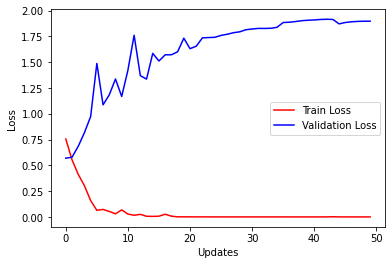

In [ ]:
#plotting losses
epoch = np.arange(len(train_losses))
fig_scores = plt.figure()
plt.plot(epoch, train_losses, 'r', epoch, eval_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')
fig_scores.savefig('/content/drive/MyDrive/DL_klimabert/Losses_test.png')

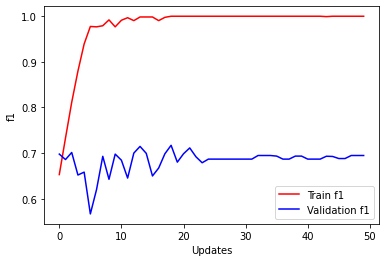

In [ ]:
#plotting f1 scores
epoch = np.arange(len(train_accuracies))
fig_scores = plt.figure()
plt.plot(epoch, f1_train_all, 'r', epoch, f1_eval_all, 'b')
plt.legend(['Train f1','Validation f1'])
plt.xlabel('Updates'), plt.ylabel('f1')
fig_scores.savefig('/content/drive/MyDrive/DL_klimabert/f1_test.png')